In [1174]:
import wikipedia
wikipedia.set_lang('en') # setting wikipedia language
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from time import sleep
import sys
import pageviewapi.period
from random import sample 

import nltk # for nlp on articles
#nltk.download("stopwords")
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# I. Data Acquisition

## Data Acquisition Utils

In [1192]:
class DataAquisitionUtils():

    @staticmethod
    def fetch_category_members(category_members, level=0, max_level=1):
        """
        Function to take all article in category (max_level control the depth of articles taken from the subcategories)
        Arguments:
        category_members - a list of category members
        level - the level at which to start getting articles
        max_level - the maximal level for the fetched articles
        Returns:
        list_articles - a list of the desired articles
        """
        list_articles = []
        for c in category_members.values():
            if c.ns == 0:
                list_articles.append(c) 
                #print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            elif level < max_level and c.ns == 14:
                sub_list = []
                sub_list = DataAquisitionUtils.fetch_category_members(c.categorymembers, level=level + 1, max_level=max_level)
                list_articles = list_articles + sub_list
        return list_articles

    @staticmethod
    def hyperlinks_matrix(list_articles):
        """
        Computes an adjacency matrix with the hyperlinks between the different articles in the argument given
        Arguments:
        list_articles - a list of articles for which to compute the hyperlink matrix
        Returns:
        matrix - a binary matrix A where A[i,j] = 1 if article i has a hyperlinkt to article j, and A[i,j] = 0 otherwise
        """
        len_time = len(list_articles)*0.05
        matrix = np.zeros((len(list_articles), len(list_articles)))
        compt = 0
        for article in list_articles:
            for link in article.links:
                for i in range(len(list_articles)):
                    if (link == list_articles[i].title):
                        matrix[compt,i] = 1
            compt = compt + 1
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int(compt/len_time), int(5*compt/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return matrix
    
    @staticmethod
    def take_words(list_articles, stop_words, is_title = False):
        """
        Function that tokenizes and returns all words in the list of articles given
        Arguments:
        list_articles - list of articles
        is_title - whether the list contains pages or just strings of titles
        Returns:
        words_df - the words in the articles in a dataframe
        """
        len_time = len(list_articles)*0.05
        words_df = pd.DataFrame(columns=['article', 'words'])
        for i in range(len(list_articles)):
            try:
                if (is_title == False):
                    page = wikipedia.page(list_articles[i].title)
                else:
                    page = wikipedia.page(list_articles[i])
            except wikipedia.DisambiguationError as e:
                s = e.options
                s = list(filter(lambda x : x != "", s))
                try :
                    page = wikipedia.page(s)
                except wikipedia.DisambiguationError as e:
                    pass
            except wikipedia.PageError:
                pass
            words = word_tokenize(page.content)
            words = [elem.lower() for elem in words]
            words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
            words_wostop = [x for x in words if x not in stop_words]
            words_wostop = [elem.lower() for elem in words_wostop]
            if (is_title == False):
                words_df.loc[i] = [list_articles[i].title] + [words_wostop]
            else:
                words_df.loc[i] = [list_articles[i]] + [words_wostop]
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int((i+1)/len_time), int(5*(i+1)/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return words_df
    
    @staticmethod
    def page_view(list_articles): 
        len_time = len(list_articles)*0.05
        view_df = pd.DataFrame(columns=['article', 'views'])
        for i in range(len(list_articles)):
            try: 
                view_df.loc[i] = [list_articles[i].title] + [pageviewapi.period.sum_last('en.wikipedia', list_articles[i].title, last=30,
                        access='all-access', agent='all-agents')]
            except pageviewapi.client.ZeroOrDataNotLoadedException as e:
                view_df.loc[i] = 0
            except wikipedia.PageError:
                pass
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int((i+1)/len_time), int(5*(i+1)/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return view_df

## NLP Utilities

In [359]:
class NLPUtilities():
    
    @staticmethod
    def TF_IDF(words_df, nb_words):
        """
        Function to get the words with the top TF-IDF scores
        Arguments:
        words_df - the dataframe consisting of the words to be considered
        nb_words - the number of words we would like the function to return
        Returns:
        df - a dataframe containing the words with the best TF-IDF scores
        """
        #remove strings like "10,000"
        #religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
        #only keep strings that contain alphabet chars
        words_df['words'] = words_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
        # create a column with all words concatenated
        words_df['words_string'] = words_df['words'].apply(lambda words_list: " ".join(words_list))

        cv=CountVectorizer()
        word_count_vector=cv.fit_transform(words_df['words_string'])

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)

        # count matrix
        count_vector=cv.transform(words_df['words_string'])

        # tf-idf scores
        tf_idf_vector=tfidf_transformer.transform(count_vector)

        feature_names = cv.get_feature_names()
        
        dense = tf_idf_vector.todense()
        denselist = dense.tolist()
                
        #tf_idf = matrix where rows are articles and columns are words and values are tfidf score for word in article
        tf_idf = pd.DataFrame(data=denselist, columns=feature_names, index=words_df['article'])
        
        #these are the words that have the biggest tfidf score
        important_words = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf']).head(nb_words).index.values
        
        #only keep the most important words in matrix
        tf_idf = tf_idf[important_words]

        return tf_idf

## Data Acquisition Pipeline

### Fetching the articles of interest

In [1193]:
aquire = DataAquisitionUtils()

In [1135]:
wiki_wiki = wikipediaapi.Wikipedia('en') # getting articles in english
# fetching the articles for categories of interest
religion_page = wiki_wiki.page("Category:Religion")
science_page = wiki_wiki.page("Category:Science")
religion_articles = aquire.fetch_category_members(religion_page.categorymembers)
science_articles = aquire.fetch_category_members(science_page.categorymembers)

We will balance the number of articles in each section 

In [1179]:
# we keep the first article which is the Science or Religion article and sample randomly from the rest
number_articles = min(len(religion_labeled_df), len(science_labeled_df))
religion_articles = [religion_articles[0]] + sample(religion_articles,number_articles)
science_articles = [science_articles[0]] + sample(science_articles,number_articles)
list_articles = religion_articles + science_articles

### Hyperlink matrix

This is the adjacency matrix of the hyperlinks between articles. That is if one article Ai links to another article Aj there will be an 1 in the ith row and jth column of the matrix.   

In [364]:
# EXECUTE IF YOU DO NOT HAVE CSV
# list_articles = religion_articles + science_articles
# adjacency_matrix = aquire.hyperlinks_matrix(list_articles)
# num_edges = np.count_nonzero(adjacency_matrix)
# print(f"Number of edges in the feature graph: {num_edges}")
# np.savetxt('hyperlinks.csv', adjacency_matrix)

In [930]:
import pandas as pd
import zipfile

zf = zipfile.ZipFile('hyperlinks.csv.zip') 
df = pd.read_csv(zf.open('hyperlinks.csv'), header=None, sep = " ")

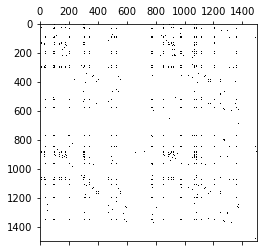

In [962]:
hyperlinks = df.values
plt.spy(hyperlinks)

In [ ]:
# Computing the laplacian
laplacian = matrixu.compute_laplacian(hyperlinks, normalize=True)
lam, U = matrixu.spectral_decomposition(np.nan_to_num(laplacian))

In [ ]:
alpha = 0.99 / np.max(lam)
ideal_tk = np.reciprocal(1+alpha*lam) 

In [ ]:
plt.plot(lam, ideal_tk)

In [ ]:
order =  10
coeff = fit_polynomial(lam.real, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff.real, laplacian)

In [ ]:
graph_filter.T @ features.numpy()

### Pageviews of articles

This matrix contain the total number of views during a period of 30 days for each articles. 

In [1194]:
views_df = aquire.page_view(list_articles)

[====================] 100%

### Taking the words with the highest TF-IDF

In [1130]:
#Take all the words present in the articles that are not stopwords
stop_found = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'mathcal', '\nu', '\partial'] #getting the stopwords found in the articles after exmination
stop_pre = stopwords.words('english') # getting the common english stopwords
stop_words = stop_found + stop_pre

In [ ]:
religion_df = pd.read_pickle('./religion_articles')
science_df = pd.read_pickle('./science_articles')

In [1167]:
#Execute only if you don't have the pickles
religion_df= aquire.take_words(religion_articles, stop_words)
religion_df = religion_df.drop_duplicates('article')

[====================] 99%

In [1184]:
#Execute only if you don't have the pickles
science_df = aquire.take_words(science_articles, stop_words)
science_df = science_df.drop_duplicates('article')

[====================] 100%

In [1231]:
religion_labeled_df = religion_df.copy()
religion_labeled_df['label'] = 0

science_labeled_df = science_df.copy()
science_labeled_df['label'] = 1

# we select the same number of articles from both categories
# we need a maximal number of data points for a good training process
number_articles = min(len(religion_labeled_df), len(science_labeled_df))

words_df_reduced = pd.concat([religion_labeled_df,\
                              science_labeled_df],\
                             ignore_index=True)
                              
labels_df = pd.DataFrame(words_df_reduced['label'])
words_df_reduced

,article,words,label
0,Religion,"[religion, social-cultural, system, designated...",0
1,African and African-American women in Christia...,"[christianity, africa, began, egypt, middle, 1...",0
2,Religion and agriculture,"[religion, agriculture, closely, associated, s...",0
3,American Anglican Church,"[anglican, church, north, america, acna, chris...",0
4,American Humanist Association,"[american, humanist, association, aha, non-pro...",0
...,...,...,...
1472,Creativity,"[creativity, phenomenon, whereby, something, n...",1
1473,Ergonomic glove,"[ergonomic, glove, also, known, computer, glov...",1
1474,DNA sequencer,"[dna, sequencer, scientific, instrument, used,...",1
1475,List of abuse allegations made through facilit...,"[instances, person, facilitated, communication...",1


In [1232]:
nlpu = NLPUtilities()

In [1233]:
# UNCOMMENT & EXECUTE IF YOU DO NOT HAVE tf_idf_50_words.pickle
tf_idf = nlpu.TF_IDF(words_df_reduced, 50)
#tf_idf = pd.read_pickle('tf_idf_50_words.pickle')
#tf_idf

In [1234]:
important_words_df = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf'])
important_words_df.head(10)

,tfidf
science,44.780375
religion,40.360663
religious,37.352622
also,27.245895
god,25.984154
scientific,22.375240
one,21.610772
church,21.152889
research,20.845156
new,18.711279


The weighted TF-IDF matrix $W_{w}$ is our tf_idf dataframe.

In [1235]:
features_weight = tf_idf

For the non-weighted TF-IDF $W_{nw}$ where we compute the weights such that for all $i,j$

$(W_{nw})_{i,j} = 1$ if $(W_{w})_{i,j} > 0$, $(W_{nw})_{i,j} = 0$ otherwise

we can do the following

In [1236]:
features_no_weight = tf_idf.where(tf_idf <= 0, 1)

For the rest of this project we choose to work with the weighted TF-IDF matrix as it gives more insights into word importance.

In [1237]:
features = features_weight

We have hence aquired the data and put it in a dataframe called features. Its rows are the different articles and each column is an important word (according to TF-IDF scores).

# II. Data Exploration

In [1238]:
from scipy.spatial.distance import pdist, squareform
import operator
from sklearn.manifold import TSNE

## Matrix Utilities

In [1239]:
class MatrixUtils():
    
    @staticmethod
    def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
        """ 
        Fnction to compute the epsilon similarity graph seen in class
        Arguments:
        X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Returns:
        adjacency (n x n ndarray): adjacency matrix of the graph.
        """
        adjacency = np.exp((- X**2)/(2 * sigma**2))
        adjacency[adjacency > epsilon] = 0
        #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
        np.fill_diagonal(adjacency,0)
        return adjacency
    
    @staticmethod
    def compute_laplacian(adjacency: np.ndarray, normalize: bool):
        """ 
        Function to compute the laplacian
        Arguments:
        adjacency - an adjacency matrix for which to compute the laplacian
        normalize - if set to True, the normalized laplacian is returned, otherwise the combinatorial one is returned 
        Returns:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
        """
        degrees_l = np.sum(adjacency,axis=1)
        if(not normalize):
            degrees = np.zeros(adjacency.shape)
            np.fill_diagonal(degrees,degrees_l)
            return degrees - adjacency 
        else:
            degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
            L = - adjacency/degrees
            np.fill_diagonal(L,np.ones(len(adjacency)))
            return L
    
    @staticmethod
    def spectral_decomposition(laplacian: np.ndarray):
        """
        Function to carry out spectral decomposition on a given matrix
        Arguments:
        laplacian - matrix on which to carry out decomposition
        Returns:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
        """
        values, vectors = np.linalg.eig(laplacian)
        sorted_indices = np.argsort(values)
        return values[sorted_indices], vectors[:,sorted_indices]
    
    @staticmethod
    def GFT(signal: np.ndarray):
        """
        Function to compute the fourier transform of a signal
        Arguments:
        signal - the signal for which to compute the fourier transform (in the form of an Numpy array)
        Returns:
        fourier - the fourier transform of the signal provided
        """
        fourier = U.transpose()@signal
        return fourier
    
    @staticmethod
    def iGFT(fourier_coefficients: np.ndarray):
        """
        Function to compute the signal from a fourier transform
        Arguments:
        fourier_coefficients - the fourier coefficients from which to get the signal (in the form of an Numpy array)
        Returns:
        signal - the signal for the fourier coefficients given
        """
        signal = U@fourier_coefficients
        return signal

## Filter Utilities

In [1240]:
class FilterUtilities():
    
    @staticmethod    
    def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
        """
        Function to apply an idea filter to a graph
        Arguments:
        x - the signal on which to apply the filter
        spectral_response - the spectral response of the signal
        Returns:
        filtered_graph - a filtered signal
        """
        fourier = MatrixUtils().GFT(x);
        h = np.diag(spectral_response)
        filtered_graph = U@h@fourier
        return filtered_graph

In [1241]:
class VisUtils():
    
    @staticmethod
    def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
        """
        Function to compute the laplacian eigenmap if a given matrix
        Arguments:
        X - the matrix for which to compute the eigenmaps
        dim - the dimension of the data we would like to return
        sigma - the sigma parameter for the epsilon similarity graph
        epsilon - the epsilon parameter for the epsilon similarity graph
        normalize - if set to True, the normalized laplacian is used, otherwise the combinatorial one is used 
        Returns:
        coords (n x dim array): new coordinates for the data points
        """
        adjacency = MatrixUtils().epsilon_similarity_graph(X, sigma, epsilon)
        laplacian = MatrixUtils().compute_laplacian(adjacency, normalize)
        eigenvalues, eigenvectors = MatrixUtils().spectral_decomposition(np.nan_to_num(laplacian)) 
        return (eigenvectors[:,1:dim+1])

## A/ Build an adjacency matrix

1/ Compute distances between articles

In [1497]:
from numpy import dot
from numpy.linalg import norm

def cosine(a,b):
    """
    Function to compute the cosine similarity between two vectors
    Arguments:
    a - first vector
    b - second vector
    Returns:
    cos_sim - the cosine similarity between a and b
    """
    if(norm(a) == 0 or norm(b) == 0):
        return dot(a,b)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

def cosine_distances(features):
    features_a = np.array(features)

    #compute cosine similarity between all articles
    distances = np.array([[cosine(features_a[i,:],features_a[j,:]) for i in range(0,features_a.shape[0])]
        for j in range(0,features_a.shape[0])]).reshape(features.shape[0],-1)

    return distances

In [1503]:
features_a = np.array(features)
distances = cosine_distances(features_a)
distances_religion = cosine_distances(features_a[labels_df_wo[labels_df_wo["label"] == 0].index])
distances_science = cosine_distances(features_a[labels_df_wo[labels_df_wo["label"] == 1].index])

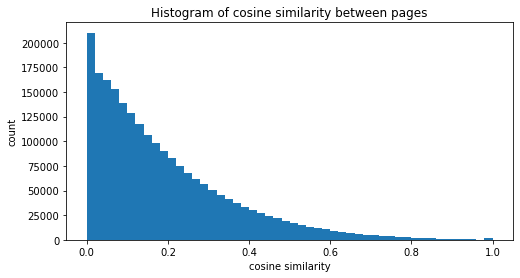

95.0% of the distances between pages are below:  0.5285327720169993


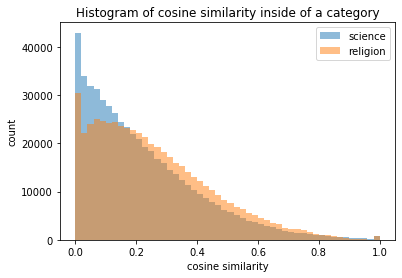

95.0% of the distances between religion pages are below:  0.623150457248326
95.0% of the distances between science pages are below:  0.592263134632401


In [1504]:
#histogram of cosine similarity

plt.figure(1, figsize=(8, 4))
plt.title("Histogram of cosine similarity between pages")
plt.hist(distances .flatten(),bins =50);
plt.xlabel('cosine similarity')
plt.ylabel('count')
plt.show()

quantile = 0.95
print(f"{quantile*100}% of the distances between pages are below: ", np.quantile(distances,quantile))

plt.title("Histogram of cosine similarity inside of a category")
plt.hist(distances_science.flatten(), bins = 50 , alpha=0.5, label='science')
plt.hist(distances_religion.flatten(), bins = 50, alpha=0.5, label='religion')
plt.xlabel('cosine similarity')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.show()

print(f"{quantile*100}% of the distances between religion pages are below: ",  np.quantile(distances_religion,quantile))
print(f"{quantile*100}% of the distances between science pages are below: ", np.quantile(distances_science,quantile))


We notice a heavy-tailed distribution. The similarity between papers is hence concentrated around 0 and 0.2 between most papers but there are some rare papers with very high cosine similarity scores.

Let's examine an example of distance distribution for one religon paper

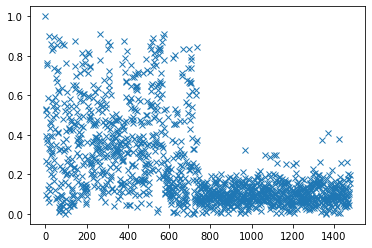

In [1505]:
plt.plot(distances[0],'x')

Let's examine an example of distance distribution for one scientific paper

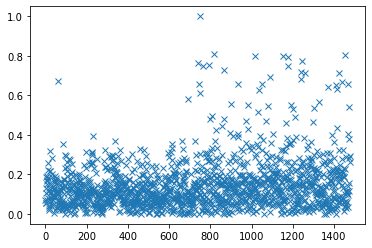

In [1507]:
plt.plot(distances[752],'x')

2/ Adjacency Matrix

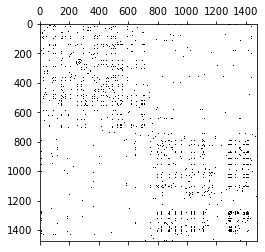

In [1508]:
def article_sim_th(threshold, distances=distances,weight=True):
    """
    apply a threshold to cosine distances in order to get an adjacency matrix that 
    allow to observe the two classes of articles
    """
    feat = distances.copy()
    if(weight):
        feat[feat<threshold]=0
    else:
        feat = np.where(distances > threshold, 1, 0)
    np.fill_diagonal(feat, 0)
    return feat

# according to previous part approximatly 95% of the articles of given category have cosine distances above 0.6
# we will keep this value as a threshold, distances that are below 0.6, won't be taken in account in our adjacency matrix
adjacency = article_sim_th(0.64,weight=True)

plt.spy(adjacency)
plt.show()

## B/ Exploring graph properties

In [1510]:
import collections
import matplotlib.pyplot as plt
import networkx as nx

1/ General features

In [1511]:
# building a graph using the normalized distances
graph = nx.from_numpy_matrix(adjacency)

# assessing the giant component size
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

print("average clustering coefficient of our graph:",nx.average_clustering(graph))

The giant component of the feature graph has 1459 nodes and 23245 edges.
average clustering coefficient of our graph: 0.5285367062819631


In [1512]:
#study the connected components
graphs = list(nx.connected_component_subgraphs(graph))
for i in range(0,len(graphs)):
    print("subgraph nb ", i, "nb of nodes:",len(graphs[i].degree))

subgraph nb  0 nb of nodes: 1459
subgraph nb  1 nb of nodes: 1
subgraph nb  2 nb of nodes: 1
subgraph nb  3 nb of nodes: 1
subgraph nb  4 nb of nodes: 1
subgraph nb  5 nb of nodes: 1
subgraph nb  6 nb of nodes: 1
subgraph nb  7 nb of nodes: 1
subgraph nb  8 nb of nodes: 1
subgraph nb  9 nb of nodes: 1
subgraph nb  10 nb of nodes: 1
subgraph nb  11 nb of nodes: 2
subgraph nb  12 nb of nodes: 1
subgraph nb  13 nb of nodes: 1
subgraph nb  14 nb of nodes: 1
subgraph nb  15 nb of nodes: 1
subgraph nb  16 nb of nodes: 1
subgraph nb  17 nb of nodes: 1


The graph has one giant component and a small component composed of 2 nodes, the 16 other components are pages that are alone.

In [1514]:
nodes_small_comp = list(graphs[11].nodes())

#for curiosity, articles linked in the small component
for node in nodes_small_comp:
     print(features.index[node])

Induced-self antigen
Rope worms


2/ Degree distribution

NameError: name 'er_degrees' is not defined

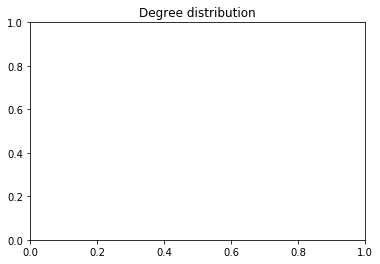

In [1522]:
plt.title("Degree distribution")
degrees = [d for (i,d) in graph.degree()]
plt.hist(er_degrees,bins = 50);
plt.xlabel('degree')
plt.ylabel('count')
plt.show()

The distribution of the degree follows a power law, hence the garph corresponds to a scale free network.

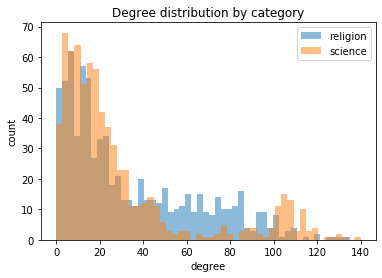

In [1520]:
#observe articles with highest degree

list_degree = list(graph.degree)
degree_religion = []
degree_science = []
data= []

for node in list_degree:
    if(node[0]<=751):
        category = "religion"
        degree_religion.append(node[1])
    else:
        category = "science"
        degree_science.append(node[1])
    article_name = features.index[node[0]]
    degree = node[1]
    
    data.append([article_name,category,degree])
    
df = pd.DataFrame(data, columns = ['Article Name', 'Category','Degree'])

plt.title("Degree distribution by category")
plt.hist(degree_religion, bins = 50 , alpha=0.5, label='religion')
plt.hist(degree_science, bins = 50, alpha=0.5, label='science')
plt.xlabel('degree')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.show()

2/ Articles with highest and lowest degrees

In [1521]:
#articles with highest degree
df.sort_values(by=['Degree'],ascending=False)[:12]

,Article Name,Category,Degree
1139,Logology (science),science,140
145,Criticism of religion,religion,135
1324,Antiscience,science,133
1237,"Little Science, Big Science",science,131
739,Science,religion,131
926,Fringe science,science,130
311,Spiritual but not religious,religion,128
1308,Women in science,science,127
372,Religious pluralism,religion,125
1423,Scientometrics,science,124


## Exploring possible clustering in the graph

In [1247]:
matrixu = MatrixUtils()

In [1475]:
nodes_df = pd.DataFrame(range(len(adjacency)), columns = ["X"])
nodes_df["Y"] = np.zeros((len(adjacency)))

In [1476]:
epsilon_df = pd.DataFrame(np.argwhere(adjacency != 0), columns = ["X","Y"] ).drop_duplicates(subset = "X")
epsilon_wo = epsilon_df.merge(nodes_df, on = ["X"], how= "right")

### Removing the nodes that are not connected

In [1477]:
removed_df = words_df_reduced[words_df_reduced["article"].isin(tf_idf.iloc[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]].index)]
removed_df

,article,words,label,words_string
134,Buber-Rosenzweig-Medal,"[annual, prize, awarded, since, deutscher, koo...",0,annual prize awarded since deutscher koordinie...
194,Bar Ilan Responsa Project,"[bar, ilan, responsa, project, global, jewish,...",0,bar ilan responsa project global jewish databa...
391,Niraj Jain,"[pandit, niraj, jain, october, march, scholar,...",0,pandit niraj jain october march scholar jainis...
536,Hierotopy,"[hierotopy, ancient, greek, ἱερός, sacred, anc...",0,hierotopy ancient greek ἱερός sacred ancient g...
685,Prorrhesis,"[part, eleusinian, mysteries, prorrhesis, offi...",0,part eleusinian mysteries prorrhesis official ...
721,Spiritual literature,"[spiritual, literature, genre, literature, usu...",0,spiritual literature genre literature usually ...
732,Transfiguration (religion),"[religious, context, transfiguration, latin, t...",0,religious context transfiguration latin transf...
804,Endophysics,"[endophysics, literally, means, physics, withi...",1,endophysics literally means physics within stu...
915,Nature center,"[nature, center, nature, centre, organization,...",1,nature center nature centre organization visit...
1144,Science attaché,"[diplomacy, attaché, person, assigned, attache...",1,diplomacy attaché person assigned attached dip...


In [1478]:
mean_nb_words_removed = len(removed_df["words"].explode())/len(removed_df)
print("The mean number of words of the removed articles are " + str(mean_nb_words_removed))

The mean number of words of the removed articles are 297.7857142857143


In [1479]:
views_df_removed = views_df.merge(removed_df, on = "article")
mean_nb_views_removed = views_df_removed["views"].sum()/len(views_df_removed)
print("The mean number of views of these articles are " + str(mean_nb_views_removed) + " per month")

The mean number of views of these articles are 5518.461538461538 per month


In [1480]:
mean_nb_words = len(words_df_reduced["words"].explode())/len(words_df_reduced)
print("The mean number of words of the articles are " + str(mean_nb_words))

The mean number of words of the articles are 828.5795531482735


In [1481]:
mean_nb_views = views_df["views"].sum()/len(views_df)
print("The mean number of views of the articles are " + str(mean_nb_views) + " per month")

The mean number of views of the articles are 6581.863031914893 per month


The removed articles belong to the religon and science articles with approximatively the same proportion, excluding a possible bias that could happen when removing articles. Furthermore, these articles are mostly short articles. We can claim that these articles are stub and need more expansion and devolepment. The mean number of views for the removed articles are way less than for the total articles, adding to the supposition that htese articles are stubs. 

In [1482]:
distances_wo = np.delete(distances, epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"], 0)
distances_wo = np.delete(distances_wo, epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"], 1)
tf_idf_wo = tf_idf.drop(tf_idf.iloc[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]].index.values)
labels_df_wo = labels_df.drop(labels_df.index[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]]).reset_index()

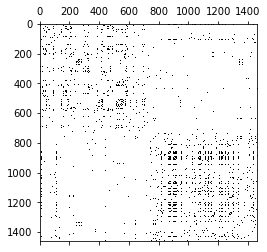

In [1523]:
adjacency_wo = article_sim_th(0.59,distances_wo, weight=True)

plt.spy(adjacency_wo)
plt.show()

## Visualizing the graph obtained

In [ ]:
visu = VisUtils()

#### Laplacian Eigenmaps

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

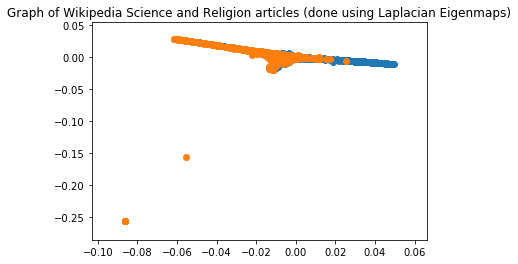

In [1524]:
laplacian = matrixu.compute_laplacian(adjacency_wo, normalize=True)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(np.nan_to_num(laplacian)) 
twoD_embeddings = (eigenvectors[:,1:3])
plt.scatter(twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 0].index,0], twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 0].index,1], label=1)
plt.scatter(twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 1].index,0], twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 1].index,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

### t-sne

In [1527]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
x_embed = tsne.fit_transform(distances_wo)

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using tSN-E)')

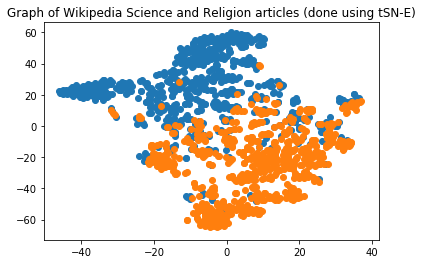

In [1528]:
plt.scatter(x_embed[labels_df_wo[labels_df_wo["label"] == 0].index,0], x_embed[labels_df_wo[labels_df_wo["label"] == 0].index,1], label=1)
plt.scatter(x_embed[labels_df_wo[labels_df_wo["label"] == 1].index,0], x_embed[labels_df_wo[labels_df_wo["label"] == 1].index,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using tSN-E)')

# III. Machine Learning

## Heuristic Eigengaps

In [1529]:
laplacian = matrixu.compute_laplacian(adjacency_wo, normalize = True)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(laplacian)

Text(0.5, 1.0, 'Eigenvalues $L_{comb}$')

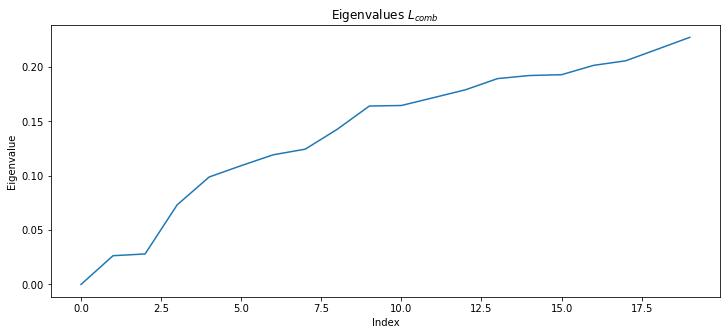

In [1530]:
plt.figure(figsize=(12,5))
plt.plot(eigenvalues[0:20])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')

The heuristic eigengaps state that the number of clusters need to be equal to the index of eigenvalues with the largest difference between themselves. However, here there is no clear cut except maybe for the index 2 that have a large eigengap.

## Unsupervised learning

In [1539]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method =  None
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        laplacian = matrixu.compute_laplacian(adjacency, self.normalize)
        lamb, U = matrixu.spectral_decomposition(laplacian)
        Y = U[:,0:self.n_classes].real
        kmeans = KMeans(n_clusters = self.n_classes).fit(Y)
        y_pred =  kmeans.predict(Y)
        centers = kmeans.cluster_centers_
        return y_pred, centers

### The clusters

In [1540]:
def make_clusters(adjacency, nb_clusters) : 
    spectral_clustering = SpectralClustering(n_classes=nb_clusters, normalize=True)
    y_pred, centers = spectral_clustering.fit_predict(adjacency)
    y_pred = pd.DataFrame(y_pred, columns = ["label"])
    laplacian = matrixu.compute_laplacian(adjacency, True)
    lamb, U = matrixu.spectral_decomposition(laplacian)
    Y = U[:,0:nb_clusters].real
    clusters_df = pd.DataFrame([tf_idf_wo.columns.values[np.argsort(-(Y @ centers.T).T@tf_idf_wo.values, 1)[i][:10]] for i in range(nb_clusters)]).T
    clusters_df.index = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    clusters_df.loc[0] = tf_idf_wo.index[np.argmax(Y @ centers.T, 0)]
    clusters_df.loc[1] = [words_df_reduced.explode("words").groupby(["article"]).count().iloc[y_pred[y_pred["label"] == i].index].sort_values(by = ["words"], ascending = False).index[0] for i in range(nb_clusters)]
    clusters_df.loc[2] = [views_df.merge(words_df_reduced.iloc[y_pred[y_pred["label"] == i].index], on = "article").sort_values(by = ["views"], ascending = False).iloc[0]["article"] for i in range(nb_clusters)]
    clusters_df.loc[13] = [len(y_pred[y_pred["label"] == i]) for i in range(nb_clusters)]
    clusters_df.loc[14] = [100 - (labels_df_wo.iloc[y_pred[y_pred["label"] == i].index].sum().values[-1:]*100 / len(y_pred[y_pred["label"] == i])) for i in range(nb_clusters)]
    clusters_df.loc[15] = [labels_df_wo.iloc[y_pred[y_pred["label"] == i].index].sum().values[-1:]*100 / len(y_pred[y_pred["label"] == i]) for i in range(nb_clusters)]
    clusters_df.sort_index(inplace=True)
    clusters_df.index = ["Most relevant article", "Longest article", "Most viewed article", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "Number of articles","Percentage of religion article", "Percentage of science articles"]
    return clusters_df, y_pred

In [1541]:
clusters_df, y_pred = make_clusters(adjacency_wo, 2)
clusters_df

,0,1
Most relevant article,Criticism of religion,Science
Longest article,Criticism of Islam,Well-being contributing factors
Most viewed article,List of religious populations,Myers–Briggs Type Indicator
1,religion,science
2,religious,scientific
3,god,research
4,church,technology
5,religions,also
6,christian,university
7,one,religion


# Supervised Learning

In [1534]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import DGLGraph
import dgl.function as fn

np.random.seed(0)
torch.manual_seed(1)

In [1535]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [1536]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
       
def test_articles(model, g, features, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] 
        _, indices = torch.max(logits, dim=1)
        return indices

In [1542]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    adjacency_wo, y_pred['label'], range(adjacency_wo.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

In [1543]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train_ = y_pred.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val_ = y_pred.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test_ = y_pred.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

In [1545]:
in_feats = tf_idf_wo_filt.shape[1] 
n_classes = 2
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features_ = torch.FloatTensor(tf_idf_wo.values) 
labels = torch.LongTensor(y_pred['label']) 
train_mask = torch.BoolTensor(train_['indices'])
val_mask = torch.BoolTensor(val_['indices'])
test_mask = torch.BoolTensor(test_['indices'])

In [1546]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph_wo = nx.from_numpy_matrix(adjacency)
graph = DGLGraph(graph_wo)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features_, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features_, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features_, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

RuntimeError: size mismatch, m1: [1463 x 50], m2: [100 x 2] at /Users/distiller/project/conda/conda-bld/pytorch_1565272526878/work/aten/src/TH/generic/THTensorMath.cpp:752

In [ ]:
coeff_gcn =  model.pol_weights.data.numpy()
print(coeff_gcn)

In [1060]:
model

LaplacianPolynomial(
  in=100, out=6, normalization=True
  (dropout): Dropout(p=0.8, inplace=False)
)

In [1061]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here
    V = np.vander(lam, len(coeff), increasing=True)
    return V@coeff

Text(0, 0.5, 'Spectral response (db)')

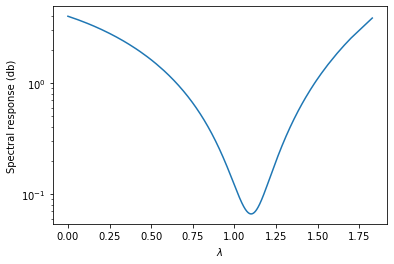

In [1062]:
plt.semilogy(lamb, np.abs(polynomial_graph_filter_response(coeff_gcn, lamb)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

In [1063]:
list_articles = ["God", "Network Science", "Jesus", "Quantic physics"]
test_df = aquire.take_words(list_articles, stop_words, is_title = True)

[====================] 100%

In [1064]:
test_df = pd.concat([words_df_reduced,test_df])

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [1065]:
features_final = nlpu.TF_IDF(test_df, 100).values
features_final

array([[0.04042863, 0.54163663, 0.26061566, ..., 0.01383232, 0.02608606,
        0.00361969],
       [0.        , 0.02340949, 0.03985647, ..., 0.        , 0.01944829,
        0.        ],
       [0.        , 0.06943664, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06263579, 0.        , 0.        , ..., 0.00252121, 0.0095094 ,
        0.01319519],
       [0.        , 0.00347259, 0.01576626, ..., 0.11286383, 0.00256443,
        0.00142335],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [1066]:
distances = np.array([[(np.sum((features_final[i,:]-features_final[j,:])**2)) for i in range(0,features_final.shape[0]) ] for j in range(0,features_final.shape[0])]).reshape(features_final.shape[0],-1)
feat = distances/np.max(distances)
np.fill_diagonal(feat, 0)
graph = nx.from_numpy_array(feat)
graph = DGLGraph(graph)

In [1067]:
features_ = torch.FloatTensor(features_final)

In [1068]:
mask1 = np.zeros((len(features)))
mask2 = np.ones((4))
mask = np.concatenate((mask1,mask2))
mask = torch.BoolTensor(mask)

In [1069]:
test_articles(model, graph, features_, mask)

IndexError: The shape of the mask [1404] at index 0does not match the shape of the indexed tensor [1506, 6] at index 0

In [967]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    provisory = np.eye(len(laplacian))
    h = coeff[0]*np.eye(len(laplacian)) 
    
    for i in range (1,len(coeff)):
        provisory =  provisory@laplacian
        h += coeff[i]*provisory 
    return h

In [973]:
polynomial_graph_filter(coeff_gcn, laplacian)[0]

array([-1.44496764e+07,  0.00000000e+00,  3.06946925e+04, ...,
        1.03254147e+01,  0.00000000e+00,  0.00000000e+00])

In [971]:
features_.shape

torch.Size([1404, 100])